# Algorithms for Massive Data
# Project - Plant Leaves Recognizer
# David Fernandez - 988346

The task is to implement a deep-learning-based system classifying pictures of leaves according to the twelve types of plants

In [1]:
#import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.random import seed
from numpy import array
from numpy import argmax
import seaborn as sns
import random
import cv2
import os
import pickle
import shutil

os.environ['PYTHONHASHSEED']=str(2)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, load_model

from keras.layers import PReLU
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import graphviz
import pydot
import visualkeras
from PIL import ImageFont

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(2)
   tf.random.set_seed(2)
   np.random.seed(2)
   random.seed(2)

In [2]:
reset_random_seeds()

In [ ]:
#download data from Kaggle
import zipfile
import os

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

path = "D:\\Data\\"

os.environ['KAGGLE_USERNAME'] = "davidheilbron"
os.environ['KAGGLE_KEY'] = "60686e2d39aaab30b0ba19230091fcbe"
!kaggle datasets download -d csafrit2/plant-leaves-for-image-classification -p $path


In [ ]:
# unzip data
with zipfile.ZipFile(os.path.join(path, 'plant-leaves-for-image-classification.zip'), 'r') as zip_ref:
    zip_ref.extractall(path)

In [ ]:
#show random images from training dataset
import random
from PIL import Image
from skimage.io import imread

path = r"D:\\Data\\Plants_2\\train"

images = []
for folder in os.listdir(path):
  for image in os.listdir(path + '/' + folder):
    images.append(os.path.join(path, folder, image))
      
plt.figure(1, figsize=(15, 9))
n = 0
for i in range(16):
  n += 1
  random_img = random.choice(images)
  imgs = imread(random_img)
  plt.subplot(4, 4, n)
  plt.imshow(imgs)

plt.savefig(r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\sample.jpeg", dpi = 200)
plt.show()


In [ ]:
#Total number of images on each parent folder

def count_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len(files)
    return count

path = r"D:\\Data\\Plants_2\\images to predict"
num_files = count_files(path)
print("Total number of images in images to predict", num_files)

path = r"D:\\Data\\Plants_2\\test"
num_files = count_files(path)
print("Total number of images in test", num_files)

path = r"D:\\Data\\Plants_2\\train"
num_files = count_files(path)
print("Total number of images in train", num_files)

path = r"D:\\Data\\Plants_2\\valid"
num_files = count_files(path)
print("Total number of images in valid", num_files)


In [ ]:
#How many files do we have on the test folder?

path = r"D:\\Data\\Plants_2\\test"
image_counts = {}

for root, dirs, files in os.walk(path):
    count = 0
    for file in files:
        count += 1
    if count > 0:
        image_counts[root] = count

# Display the image counts for each folder
if image_counts:
    for folder, count in image_counts.items():
        print("Folder", folder, "contains", count, "images.")
else:
    print("No images found in subfolders of", path)

In [ ]:
# fix Basil diseaded folder name

old_folder_name = r"D:\\Data\\Plants_2\\test\\Bael diseased (P4b)"
new_folder_name = r"D:\\Data\\Plants_2\\test\\Basil diseased (P4b)"

os.rename(old_folder_name, new_folder_name)

old_folder_name = r"D:\\Data\\Plants_2\\train\\Bael diseased (P4b)"
new_folder_name = r"D:\\Data\\Plants_2\\train\\Basil diseased (P4b)"

os.rename(old_folder_name, new_folder_name)

old_folder_name = r"D:\\Data\\Plants_2\\valid\\Bael diseased (P4b)"
new_folder_name = r"D:\\Data\\Plants_2\\valid\\Basil diseased (P4b)"

os.rename(old_folder_name, new_folder_name)

In [ ]:
#How many files do we have on the training folder?

path = r"D:\\Data\\Plants_2\\train"
image_counts = {}
count = 0

for root, dirs, files in os.walk(path):
    count = 0
    for file in files:
        count += 1
    if count > 0:
        image_counts[root] = count

# Display the image counts for each folder
if image_counts:
    for folder, count in image_counts.items():
        print("Folder", folder, "contains", count, "images.")
else:
    print("No images found in subfolders of", path)


In [ ]:
#How many files do we have on the validation folder?

path = r"D:\\Data\\Plants_2\\valid"
image_counts = {}
count = 0

for root, dirs, files in os.walk(path):
    count = 0
    for file in files:
        count += 1
    if count > 0:
        image_counts[root] = count

# Display the image counts for each folder
if image_counts:
    for folder, count in image_counts.items():
        print("Folder", folder, "contains", count, "images.")
else:
    print("No images found in subfolders of", path)

# Pre processing of training dataset

In [ ]:
# Function to create new folder if not exists
def make_new_folder(folder_name, parent_folder):
    path = os.path.join(parent_folder, folder_name)

    try:
        # mode of the folder
        mode = 0o777

        # Create folder
        os.mkdir(path, mode)
    except OSError as error:
        print(error)


In [ ]:
#Merge folders of healthy and diseased plants into a single folder

# merge Alstonia Scholaris diseased and healthy into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Alstonia Scholaris diseased (P2a)', 'Alstonia Scholaris healthy (P2b)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Alstonia Scholaris"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)

os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))


# merge Arjun folders into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Arjun diseased (P1a)', 'Arjun healthy (P1b)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Arjun"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))


# merge Basil folders into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Basil diseased (P4b)', 'Basil healthy (P8)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Basil"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))


# merge Chinar folders into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Chinar diseased (P11b)', 'Chinar healthy (P11a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Chinar"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))


# merge Gauva folders into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Gauva diseased (P3b)', 'Gauva healthy (P3a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Gauva"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))


# merge Jamun folders into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Jamun diseased (P5b)', 'Jamun healthy (P5a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Jamun"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))


# merge Jatropha folders into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Jatropha diseased (P6b)', 'Jatropha healthy (P6a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Jatropha"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))


# merge Lemon folders into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Lemon diseased (P10b)', 'Lemon healthy (P10a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Lemon"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))


# merge Mango folders into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Mango diseased (P0b)', 'Mango healthy (P0a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Mango"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))


# merge Pomegranate folders into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Pomegranate diseased (P9b)', 'Pomegranate healthy (P9a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Pomegranate"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))


# merge Pongamia Pinnata folders into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Pongamia Pinnata diseased (P7b)', 'Pongamia Pinnata healthy (P7a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Pongamia Pinnata"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

In [ ]:
#set categories
directory = r"D:\Data\Plants_2\train"
categories = ['Alstonia Scholaris', 'Arjun', 'Basil', 
              'Chinar', 'Gauva', 'Jamun', 'Jatropha', 
              'Lemon', 'Mango', 'Pomegranate', 'Pongamia Pinnata']

In [ ]:
#resize images
img_size=200

data=[]

for category in categories:
    folder=os.path.join(directory, category)
    label=categories.index(category)
    for img in os.listdir(folder):
        img_path=os.path.join(folder, img)
        img_arr=cv2.imread(img_path)
        img_arr=cv2.resize(img_arr, (img_size, img_size))
        data.append([img_arr, label])

In [ ]:
#check images size
print(len(data)) #check dataset size 
print(len(data[random.randint(0,len(data))][0])) #check if the size of a random image is 200

In [ ]:
#check data composition of an image
print(data[0][0][199])

In [ ]:
data[random.randint(0,len(data))][0]

In [ ]:
#split features and labels in data
X_train = []
y_train = []

for features, labels in data:
    X_train.append(features)
    y_train.append(labels)
    
    
#transform data to np arrays
X_train=np.array(X_train)
y_train=np.array(y_train)

#check lenght of features and labels
print(len(X_train))
print(len(y_train))

#scale features for easier processing
X_train=X_train/255

#check shape
X_train.shape

#one hot encoding for y_train
b = np.zeros((y_train.size, y_train.max() + 1))
b[np.arange(y_train.size), y_train] = 1
y_train = b

y_train[random.randint(0,len(y_train))]
y_train.shape

In [ ]:
#just in case - one hot encoding for y_train
values = array(categories)
print(values)

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)

# binary encode
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

# invert one hot encoding
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
print(inverted)

In [ ]:
#save progress
pickle.dump(X_train, open(r'D:\Data\pkl\X_train.pkl', "wb"))
pickle.dump(y_train, open(r'D:\Data\pkl\y_train.pkl', "wb"))

# Pre processing of test dataset

In [ ]:
#merge diseased and healthy folders into one single folder for each category of plant 

current_folder = r"D:\\Data\\Plants_2\\test"


#merge Alstonia Scholaris diseased and healthy into one single folder

# list of folders to be merged
list_dir = ['Alstonia Scholaris diseased (P2a)', 'Alstonia Scholaris healthy (P2b)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Alstonia Scholaris"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)

os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Arjun folders into one single folder

# list of folders to be merged
list_dir = ['Arjun diseased (P1a)', 'Arjun healthy (P1b)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Arjun"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Basil folders into one single folder

# list of folders to be merged
list_dir = ['Basil diseased (P4b)', 'Basil healthy (P8)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Basil"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Chinar folders into one single folder

# list of folders to be merged
list_dir = ['Chinar diseased (P11b)', 'Chinar healthy (P11a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Chinar"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Gauva folders into one single folder

# list of folders to be merged
list_dir = ['Gauva diseased (P3b)', 'Gauva healthy (P3a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Gauva"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Jamun folders into one single folder

# list of folders to be merged
list_dir = ['Jamun diseased (P5b)', 'Jamun healthy (P5a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Jamun"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Jatropha folders into one single folder

# list of folders to be merged
list_dir = ['Jatropha diseased (P6b)', 'Jatropha healthy (P6a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Jatropha"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Lemon folders into one single folder

# list of folders to be merged
list_dir = ['Lemon diseased (P10b)', 'Lemon healthy (P10a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Lemon"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Mango folders into one single folder

# list of folders to be merged
list_dir = ['Mango diseased (P0b)', 'Mango healthy (P0a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Mango"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Pomegranate folders into one single folder

# list of folders to be merged
list_dir = ['Pomegranate diseased (P9b)', 'Pomegranate healthy (P9a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Pomegranate"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Pongamia Pinnata folders into one single folder

# list of folders to be merged
list_dir = ['Pongamia Pinnata diseased (P7b)', 'Pongamia Pinnata healthy (P7a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Pongamia Pinnata"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

In [76]:
#set categories
directory = r"D:\Data\Plants_2\test"
categories = ['Alstonia Scholaris', 'Arjun', 'Basil', 
              'Chinar', 'Gauva', 'Jamun', 'Jatropha', 
              'Lemon', 'Mango', 'Pomegranate', 'Pongamia Pinnata']

#now, we need to merge the healty and diseased folders of each plant species

In [ ]:
#resize images
img_size=200

data=[]

for category in categories:
    folder=os.path.join(directory, category)
    label=categories.index(category)
    for img in os.listdir(folder):
        img_path=os.path.join(folder, img)
        img_arr=cv2.imread(img_path)
        img_arr=cv2.resize(img_arr, (img_size, img_size))
        data.append([img_arr, label])

In [ ]:
#check images size
print(len(data)) #check dataset size after dropping damaged images
print(len(data[random.randint(0,len(data))][0])) #check if the size of a random image is 200

In [ ]:
#split features and labels in data
X_test = []
y_test = []

for features, labels in data:
    X_test.append(features)
    y_test.append(labels)
    
    
#transform data to np arrays
X_test=np.array(X_test)
y_test=np.array(y_test)

#check lenght of features and labels
print(len(X_test))
print(len(y_test))

#scale features for easier processing
X_test=X_test/255

#check shape
X_test.shape

#one hot encoding for y_test
b = np.zeros((y_test.size, y_test.max() + 1))
b[np.arange(y_test.size), y_test] = 1
y_test = b

y_test[random.randint(0,len(y_test))]
y_test.shape

In [ ]:
#save progress
pickle.dump(X_test, open(r'D:\Data\pkl\X_test.pkl', "wb"))
pickle.dump(y_test, open(r'D:\Data\pkl\y_test.pkl', "wb"))

# Pre processing of validation dataset

In [ ]:
#merge diseased and healthy folders into one single folder for each category of plant 

current_folder = r"D:\\Data\\Plants_2\\valid"


#merge Alstonia Scholaris diseased and healthy into one single folder

# list of folders to be merged
list_dir = ['Alstonia Scholaris diseased (P2a)', 'Alstonia Scholaris healthy (P2b)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Alstonia Scholaris"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)

os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Arjun folders into one single folder

# list of folders to be merged
list_dir = ['Arjun diseased (P1a)', 'Arjun healthy (P1b)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Arjun"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Basil folders into one single folder

# list of folders to be merged
list_dir = ['Basil diseased (P4b)', 'Basil healthy (P8)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Basil"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Chinar folders into one single folder

# list of folders to be merged
list_dir = ['Chinar diseased (P11b)', 'Chinar healthy (P11a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Chinar"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Gauva folders into one single folder

# list of folders to be merged
list_dir = ['Gauva diseased (P3b)', 'Gauva healthy (P3a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Gauva"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Jamun folders into one single folder

# list of folders to be merged
list_dir = ['Jamun diseased (P5b)', 'Jamun healthy (P5a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Jamun"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Jatropha folders into one single folder

# list of folders to be merged
list_dir = ['Jatropha diseased (P6b)', 'Jatropha healthy (P6a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Jatropha"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Lemon folders into one single folder

# list of folders to be merged
list_dir = ['Lemon diseased (P10b)', 'Lemon healthy (P10a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Lemon"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Mango folders into one single folder

# list of folders to be merged
list_dir = ['Mango diseased (P0b)', 'Mango healthy (P0a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Mango"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Pomegranate folders into one single folder

# list of folders to be merged
list_dir = ['Pomegranate diseased (P9b)', 'Pomegranate healthy (P9a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Pomegranate"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Pongamia Pinnata folders into one single folder

# list of folders to be merged
list_dir = ['Pongamia Pinnata diseased (P7b)', 'Pongamia Pinnata healthy (P7a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Pongamia Pinnata"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

In [ ]:
#set categories
directory = r"D:\Data\Plants_2\valid"
categories = ['Alstonia Scholaris', 'Arjun', 'Basil', 
              'Chinar', 'Gauva', 'Jamun', 'Jatropha', 
              'Lemon', 'Mango', 'Pomegranate', 'Pongamia Pinnata']

#now, we need to merge the healty and diseased folders of each plant species

In [ ]:
#resize images
img_size=200

data=[]

for category in categories:
    folder=os.path.join(directory, category)
    label=categories.index(category)
    for img in os.listdir(folder):
        img_path=os.path.join(folder, img)
        img_arr=cv2.imread(img_path)
        img_arr=cv2.resize(img_arr, (img_size, img_size))
        data.append([img_arr, label])

In [ ]:
#check images size
print(len(data)) #check dataset size after dropping damaged images
print(len(data[random.randint(0,len(data))][0])) #check if the size of a random image is 200

In [ ]:
#split features and labels in data
X_valid = []
y_valid = []

for features, labels in data:
    X_valid.append(features)
    y_valid.append(labels)
    
    
#transform data to np arrays
X_valid=np.array(X_valid)
y_valid=np.array(y_valid)

#check lenght of features and labels
print(len(X_valid))
print(len(y_valid))

#scale features for easier processing
X_valid=X_valid/255

#check shape
X_valid.shape

#one hot encoding for y_valid
b = np.zeros((y_valid.size, y_valid.max() + 1))
b[np.arange(y_valid.size), y_valid] = 1
y_valid = b

y_valid[random.randint(0,len(y_valid))]
y_valid.shape

In [ ]:
#save progress
pickle.dump(X_valid, open(r'D:\Data\pkl\X_valid.pkl', "wb"))
pickle.dump(y_valid, open(r'D:\Data\pkl\y_valid.pkl', "wb"))

# Checkpoint - Load pickles

In [3]:
#load training data
X_train = pickle.load(open(r'D:\Data\pkl\X_train.pkl', "rb"))
y_train = pickle.load(open(r'D:\Data\pkl\y_train.pkl', "rb"))

#load test data
X_test = pickle.load(open(r'D:\Data\pkl\X_test.pkl', "rb"))
y_test = pickle.load(open(r'D:\Data\pkl\y_test.pkl', "rb"))

#load validation data
X_valid = pickle.load(open(r'D:\Data\pkl\X_valid.pkl', "rb"))
y_valid = pickle.load(open(r'D:\Data\pkl\y_valid.pkl', "rb"))

# Models and results

## Model 1

In [4]:
#def model 1

def create_model():
    model=Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2,2)))
        
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2,2)))
        
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2,2)))
        
    model.add(Flatten())
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(11, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=['accuracy'])
    return model

#create model
model=create_model()

In [5]:
#visualize architecture
font = ImageFont.truetype("arial.ttf", 18)
visualkeras.layered_view(model, legend=True, font=font, 
                         to_file=r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model1_1.png")

#visualize architecture
tf.keras.utils.plot_model(model, 
                          to_file=r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model1_2.png",
                          show_shapes=False,
                          show_dtype=False,
                          show_layer_names=False,
                          rankdir="TB",
                          expand_nested=True,
                          dpi=92,
                          layer_range=None,
                          show_layer_activations=True)

#visualize architecture and trainable parameters
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 64)       0

In [6]:
#define early stopping, callback and fit and evaluate function

#set early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=0, restore_best_weights=True)

#set model checkpoint callback, this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('model_1', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=50, BATCH_SIZE=32):
    model = None
    model = create_model()
    results = model.fit(t_x,
                        t_y,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        shuffle = True,
                        callbacks=[early_stopping, model_checkpoint],
                        validation_data=(val_x, val_y),)  
    print("Validation Score: ", model.evaluate(val_x, val_y))
    return results

In [ ]:
#save the model history in a list after fitting so that we can plot later
model_history = [] 
epochs=50
batch_size=32

print("Training: ")
model_history.append(fit_and_evaluate(X_train, X_valid, y_train, y_valid, epochs, batch_size))
print("======="*12, end="\n\n\n")

Training: 
Epoch 1/50
134/134 [==============================] - ETA: 0s - loss: 2.3271 - accuracy: 0.1540
Epoch 1: val_loss improved from inf to 2.37661, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 31s 227ms/step - loss: 2.3271 - accuracy: 0.1540 - val_loss: 2.3766 - val_accuracy: 0.1364
Epoch 2/50
134/134 [==============================] - ETA: 0s - loss: 2.1891 - accuracy: 0.2461
Epoch 2: val_loss improved from 2.37661 to 2.34895, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 31s 232ms/step - loss: 2.1891 - accuracy: 0.2461 - val_loss: 2.3490 - val_accuracy: 0.1818
Epoch 3/50
134/134 [==============================] - ETA: 0s - loss: 2.1116 - accuracy: 0.2674
Epoch 3: val_loss improved from 2.34895 to 2.26067, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 32s 238ms/step - loss: 2.1116 - accuracy: 0.2674 - val_loss: 2.2607 - val_accuracy: 0.1545
Epoch 4/50
134/134 [==============================] - ETA: 0s - loss: 2.0026 - accuracy: 0.2496
Epoch 4: val_loss improved from 2.26067 to 2.16997, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 31s 229ms/step - loss: 2.0026 - accuracy: 0.2496 - val_loss: 2.1700 - val_accuracy: 0.2000
Epoch 5/50
134/134 [==============================] - ETA: 0s - loss: 1.9125 - accuracy: 0.2639
Epoch 5: val_loss improved from 2.16997 to 2.07689, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 31s 228ms/step - loss: 1.9125 - accuracy: 0.2639 - val_loss: 2.0769 - val_accuracy: 0.1909
Epoch 6/50
134/134 [==============================] - ETA: 0s - loss: 1.8185 - accuracy: 0.3086
Epoch 6: val_loss did not improve from 2.07689
134/134 [==============================] - 29s 217ms/step - loss: 1.8185 - accuracy: 0.3086 - val_loss: 2.1488 - val_accuracy: 0.1818
Epoch 7/50
134/134 [==============================] - ETA: 0s - loss: 1.8069 - accuracy: 0.3196
Epoch 7: val_loss improved from 2.07689 to 2.03027, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 32s 238ms/step - loss: 1.8069 - accuracy: 0.3196 - val_loss: 2.0303 - val_accuracy: 0.1727
Epoch 8/50
134/134 [==============================] - ETA: 0s - loss: 1.7393 - accuracy: 0.3341
Epoch 8: val_loss did not improve from 2.03027
134/134 [==============================] - 28s 207ms/step - loss: 1.7393 - accuracy: 0.3341 - val_loss: 2.0692 - val_accuracy: 0.2182
Epoch 9/50
134/134 [==============================] - ETA: 0s - loss: 1.6372 - accuracy: 0.3854
Epoch 9: val_loss improved from 2.03027 to 1.92180, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 30s 226ms/step - loss: 1.6372 - accuracy: 0.3854 - val_loss: 1.9218 - val_accuracy: 0.2545
Epoch 10/50
134/134 [==============================] - ETA: 0s - loss: 1.5457 - accuracy: 0.4420
Epoch 10: val_loss improved from 1.92180 to 1.75403, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 30s 226ms/step - loss: 1.5457 - accuracy: 0.4420 - val_loss: 1.7540 - val_accuracy: 0.3818
Epoch 11/50
134/134 [==============================] - ETA: 0s - loss: 1.3191 - accuracy: 0.5307
Epoch 11: val_loss improved from 1.75403 to 1.45461, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 31s 233ms/step - loss: 1.3191 - accuracy: 0.5307 - val_loss: 1.4546 - val_accuracy: 0.4545
Epoch 12/50
134/134 [==============================] - ETA: 0s - loss: 1.0976 - accuracy: 0.6135
Epoch 12: val_loss improved from 1.45461 to 1.27147, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 31s 230ms/step - loss: 1.0976 - accuracy: 0.6135 - val_loss: 1.2715 - val_accuracy: 0.6091
Epoch 13/50
134/134 [==============================] - ETA: 0s - loss: 0.8930 - accuracy: 0.7000
Epoch 13: val_loss did not improve from 1.27147
134/134 [==============================] - 28s 212ms/step - loss: 0.8930 - accuracy: 0.7000 - val_loss: 1.3045 - val_accuracy: 0.5727
Epoch 14/50
134/134 [==============================] - ETA: 0s - loss: 0.7843 - accuracy: 0.7415
Epoch 14: val_loss improved from 1.27147 to 1.08143, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 33s 250ms/step - loss: 0.7843 - accuracy: 0.7415 - val_loss: 1.0814 - val_accuracy: 0.6455
Epoch 15/50
134/134 [==============================] - ETA: 0s - loss: 0.6673 - accuracy: 0.7869
Epoch 15: val_loss improved from 1.08143 to 1.00494, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 31s 231ms/step - loss: 0.6673 - accuracy: 0.7869 - val_loss: 1.0049 - val_accuracy: 0.6545
Epoch 16/50
134/134 [==============================] - ETA: 0s - loss: 0.6281 - accuracy: 0.8000
Epoch 16: val_loss improved from 1.00494 to 0.96236, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 31s 232ms/step - loss: 0.6281 - accuracy: 0.8000 - val_loss: 0.9624 - val_accuracy: 0.6727
Epoch 17/50
134/134 [==============================] - ETA: 0s - loss: 0.5551 - accuracy: 0.8238
Epoch 17: val_loss did not improve from 0.96236
134/134 [==============================] - 27s 204ms/step - loss: 0.5551 - accuracy: 0.8238 - val_loss: 1.1051 - val_accuracy: 0.6182
Epoch 18/50
134/134 [==============================] - ETA: 0s - loss: 0.5006 - accuracy: 0.8451
Epoch 18: val_loss did not improve from 0.96236
134/134 [==============================] - 28s 211ms/step - loss: 0.5006 - accuracy: 0.8451 - val_loss: 0.9891 - val_accuracy: 0.7182
Epoch 19/50
134/134 [==============================] - ETA: 0s - loss: 0.4349 - accuracy: 0.8678
Epoch 19: val_loss did not improve from 0.96236
134/134 [==============================] - 29s 215ms/step - loss: 0.4349 - accuracy: 0.8678 - val_loss: 1.0741 - val_accuracy: 0.6818
Epoch 20/50
 15/134 [==>.....

In [ ]:
# learning curve
history_dict = model_history[0].history

# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy, Model 1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model1_3.jpeg")

plt.show()

In [ ]:
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss, Model 1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model1_4.jpeg")

plt.show()

In [ ]:
#average training loss
model_1_train_loss=[]
model_1_train_loss.append(np.mean(model_history[0].history['loss']))
print(np.mean(model_1_train_loss)) #0.86765

In [ ]:
#average validation loss
model_1_val_loss=[]
model_1_val_loss.append(np.mean(model_history[0].history['val_loss']))
print(np.mean(model_1_val_loss)) #1.38

In [ ]:
#Test model 1
model = load_model('model_1')

print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)
#0.6004, 0.8364

In [ ]:
#random prediction - test set

preds = model.predict(X_test)
print(preds[109])
print(np.sum(preds[0]))

In [ ]:
#confusion matrix - test set

matrix = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
matrix

In [ ]:
#precision and recall- test set
report_model1 = classification_report(y_test.argmax(axis=1), preds.argmax(axis=1), target_names=categories, output_dict=True)
report_model1 = pd.DataFrame(report_model1).transpose().round(2)
print(report_model1)

In [127]:
print(report_model1.to_latex(position='H', bold_rows=True, float_format="{:.2f}".format, label='report_model1', caption='Classification Report, Model 1'))

\begin{table}[H]
\centering
\caption{Classification Report, Model 1}
\label{report_model1}
\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
\textbf{Alstonia Scholaris} &       0.80 &    0.80 &      0.80 &    10.00 \\
\textbf{Arjun             } &       0.83 &    1.00 &      0.91 &    10.00 \\
\textbf{Basil             } &       0.90 &    0.90 &      0.90 &    10.00 \\
\textbf{Chinar            } &       1.00 &    0.80 &      0.89 &    10.00 \\
\textbf{Gauva             } &       0.89 &    0.80 &      0.84 &    10.00 \\
\textbf{Jamun             } &       0.71 &    1.00 &      0.83 &    10.00 \\
\textbf{Jatropha          } &       0.90 &    0.90 &      0.90 &    10.00 \\
\textbf{Lemon             } &       1.00 &    0.60 &      0.75 &    10.00 \\
\textbf{Mango             } &       0.91 &    1.00 &      0.95 &    10.00 \\
\textbf{Pomegranate       } &       1.00 &    0.80 &      0.89 &    10.00 \\
\textbf{Pongamia Pinnata  } &       0.50 &    

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16360\1431214015.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(report_model1.to_latex(position='H', bold_rows=True, float_format="{:.2f}".format, label='report_model1', caption='Classification Report, Model 1'))


## Model 2

Main changes with respect to Model 1: kernel initializer is now glorot normal instead of he uniform, padding is valid instead of same and a Dropout(0.2) layer is added after each max pooling layer

In [17]:
#def model 2

def create_model():
    model=Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='valid', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
        
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='valid'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
       
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='valid'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
        
    model.add(Flatten())
    model.add(Dense(32, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(16, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(11, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=['accuracy'])
    return model

#create model
model=create_model()

In [18]:
#visualize architecture
font = ImageFont.truetype("arial.ttf", 18)
visualkeras.layered_view(model, legend=True, font=font, 
                         to_file=r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model2_1.png")

#visualize architecture
tf.keras.utils.plot_model(model, 
                          to_file=r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model2_2.png",
                          show_shapes=False,
                          show_dtype=False,
                          show_layer_names=False,
                          rankdir="TB",
                          expand_nested=True,
                          dpi=92,
                          layer_range=None,
                          show_layer_activations=True)

#visualize architecture and trainable parameters
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 99, 99, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 99, 99, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 48, 48, 32)       

In [19]:
#define early stopping, callback and fit and evaluate function

#set early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=0, restore_best_weights=True)

#set model checkpoint callback, this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('model_2', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=50, BATCH_SIZE=32):
    model = None
    model = create_model()
    results = model.fit(t_x,
                        t_y,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        shuffle = True,
                        callbacks=[early_stopping, model_checkpoint],
                        validation_data=(val_x, val_y),)  
    print("Validation Score: ", model.evaluate(val_x, val_y))
    return results

In [20]:
#save the model history in a list after fitting so that we can plot later
model_history = [] 
epochs=50
batch_size=32

print("Training: ")
model_history.append(fit_and_evaluate(X_train, X_valid, y_train, y_valid, epochs, batch_size))
print("======="*12, end="\n\n\n")

Training: 
Epoch 1/50
134/134 [==============================] - ETA: 0s - loss: 2.3505 - accuracy: 0.2122
Epoch 1: val_loss improved from inf to 2.33527, saving model to model_2


INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


134/134 [==============================] - 39s 286ms/step - loss: 2.3505 - accuracy: 0.2122 - val_loss: 2.3353 - val_accuracy: 0.1818
Epoch 2/50
134/134 [==============================] - ETA: 0s - loss: 2.1137 - accuracy: 0.2606
Epoch 2: val_loss improved from 2.33527 to 2.11941, saving model to model_2


INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


134/134 [==============================] - 35s 260ms/step - loss: 2.1137 - accuracy: 0.2606 - val_loss: 2.1194 - val_accuracy: 0.1818
Epoch 3/50
134/134 [==============================] - ETA: 0s - loss: 1.8951 - accuracy: 0.3215
Epoch 3: val_loss improved from 2.11941 to 1.97713, saving model to model_2


INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


134/134 [==============================] - 40s 296ms/step - loss: 1.8951 - accuracy: 0.3215 - val_loss: 1.9771 - val_accuracy: 0.2273
Epoch 4/50
134/134 [==============================] - ETA: 0s - loss: 1.6389 - accuracy: 0.4546
Epoch 4: val_loss improved from 1.97713 to 1.71350, saving model to model_2


INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


134/134 [==============================] - 39s 292ms/step - loss: 1.6389 - accuracy: 0.4546 - val_loss: 1.7135 - val_accuracy: 0.3636
Epoch 5/50
134/134 [==============================] - ETA: 0s - loss: 1.2917 - accuracy: 0.5653
Epoch 5: val_loss improved from 1.71350 to 1.44915, saving model to model_2


INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


134/134 [==============================] - 37s 275ms/step - loss: 1.2917 - accuracy: 0.5653 - val_loss: 1.4492 - val_accuracy: 0.4636
Epoch 6/50
134/134 [==============================] - ETA: 0s - loss: 1.1027 - accuracy: 0.6203
Epoch 6: val_loss improved from 1.44915 to 1.41859, saving model to model_2


INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


134/134 [==============================] - 34s 256ms/step - loss: 1.1027 - accuracy: 0.6203 - val_loss: 1.4186 - val_accuracy: 0.4364
Epoch 7/50
134/134 [==============================] - ETA: 0s - loss: 0.9779 - accuracy: 0.6647
Epoch 7: val_loss improved from 1.41859 to 1.10452, saving model to model_2


INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


134/134 [==============================] - 35s 262ms/step - loss: 0.9779 - accuracy: 0.6647 - val_loss: 1.1045 - val_accuracy: 0.5909
Epoch 8/50
134/134 [==============================] - ETA: 0s - loss: 0.9106 - accuracy: 0.6862
Epoch 8: val_loss improved from 1.10452 to 1.04955, saving model to model_2


INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


134/134 [==============================] - 35s 264ms/step - loss: 0.9106 - accuracy: 0.6862 - val_loss: 1.0495 - val_accuracy: 0.6636
Epoch 9/50
134/134 [==============================] - ETA: 0s - loss: 0.8660 - accuracy: 0.7106
Epoch 9: val_loss did not improve from 1.04955
134/134 [==============================] - 34s 254ms/step - loss: 0.8660 - accuracy: 0.7106 - val_loss: 1.1108 - val_accuracy: 0.5636
Epoch 10/50
134/134 [==============================] - ETA: 0s - loss: 0.8042 - accuracy: 0.7270
Epoch 10: val_loss did not improve from 1.04955
134/134 [==============================] - 34s 250ms/step - loss: 0.8042 - accuracy: 0.7270 - val_loss: 1.0652 - val_accuracy: 0.5909
Epoch 11/50
134/134 [==============================] - ETA: 0s - loss: 0.7613 - accuracy: 0.7429
Epoch 11: val_loss did not improve from 1.04955
134/134 [==============================] - 33s 249ms/step - loss: 0.7613 - accuracy: 0.7429 - val_loss: 1.1044 - val_accuracy: 0.6091
Epoch 12/50
134/134 [==========

INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


134/134 [==============================] - 37s 273ms/step - loss: 0.7344 - accuracy: 0.7494 - val_loss: 0.9530 - val_accuracy: 0.6636
Epoch 13/50
134/134 [==============================] - ETA: 0s - loss: 0.7085 - accuracy: 0.7511
Epoch 13: val_loss did not improve from 0.95299
4/4 [==============================] - 0s 57ms/step - loss: 1.0495 - accuracy: 0.6636
Validation Score:  [1.0495487451553345, 0.6636363863945007]




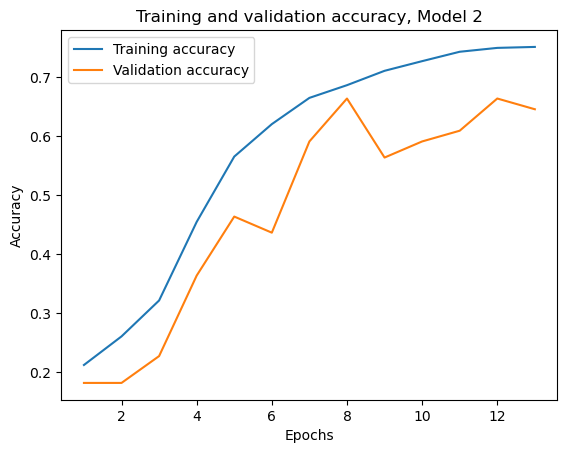

In [21]:
# learning curve
history_dict = model_history[0].history

# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy, Model 2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model2_3.jpeg")

plt.show()

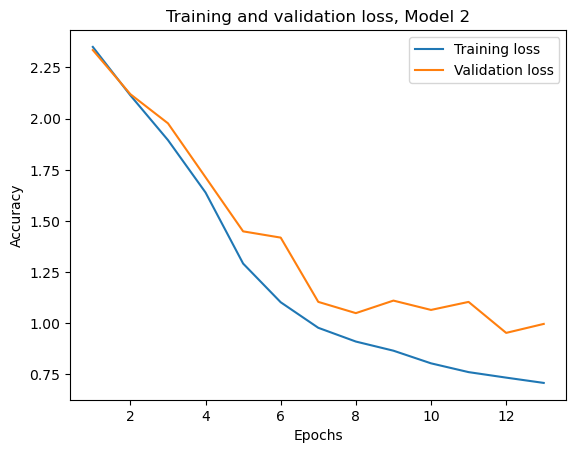

In [22]:
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss, Model 2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model2_4.jpeg")

plt.show()

In [23]:
#training and validation loss
model_2_train_loss=[]
model_2_train_loss.append(np.mean(model_history[0].history['loss']))
print(np.mean(model_2_train_loss)) #1.242

model_2_val_loss=[]
model_2_val_loss.append(np.mean(model_history[0].history['val_loss']))
print(np.mean(model_2_val_loss)) #1.415

1.2427342671614428
1.4151822374417231


In [24]:
#Test model 2
model = load_model('model_2')

print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)
#0.9652 0.6181

4/4 [==============================] - 0s 68ms/step - loss: 0.9652 - accuracy: 0.6182


[0.9652106761932373, 0.6181818246841431]

In [25]:
#random prediction - test set

preds = model.predict(X_test)
print(preds[109])
print(np.sum(preds[0]))

4/4 [==============================] - 0s 34ms/step
[4.3290813e-02 2.6936576e-04 1.1416252e-04 5.3931639e-02 1.3614862e-01
 4.8313186e-01 2.7272288e-02 2.2830648e-02 1.1876657e-03 2.8205711e-06
 2.3182014e-01]
1.0


In [26]:
#confusion matrix - test set

matrix = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
matrix

array([[ 6,  0,  0,  0,  1,  0,  0,  1,  0,  0,  2],
       [ 0,  7,  0,  0,  0,  0,  0,  0,  0,  3,  0],
       [ 0,  1,  9,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  3,  2,  0,  1,  1,  0,  0,  0,  3],
       [ 2,  0,  0,  0,  4,  2,  0,  0,  1,  0,  1],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  2,  4,  0,  0,  0,  4],
       [ 0,  1,  4,  0,  0,  0,  0,  3,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  9,  0,  0],
       [ 0,  2,  0,  0,  0,  0,  0,  0,  0,  8,  0],
       [ 0,  0,  1,  0,  1,  2,  0,  0,  0,  0,  6]], dtype=int64)

In [27]:
#precision and recall- test set
report_model2 = classification_report(y_test.argmax(axis=1), preds.argmax(axis=1), target_names=categories, output_dict=True)
report_model2 = pd.DataFrame(report_model2).transpose().round(2)
print(report_model2)

              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.70      0.67        10
           2       0.53      0.90      0.67        10
           3       1.00      0.20      0.33        10
           4       0.67      0.40      0.50        10
           5       0.56      1.00      0.71        10
           6       0.80      0.40      0.53        10
           7       0.75      0.30      0.43        10
           8       0.90      0.90      0.90        10
           9       0.73      0.80      0.76        10
          10       0.33      0.60      0.43        10

    accuracy                           0.62       110
   macro avg       0.70      0.62      0.60       110
weighted avg       0.70      0.62      0.60       110



In [ ]:
print(report_model2.to_latex(position='H', bold_rows=True, float_format="{:.2f}".format, label='report_model1', caption='Classification Report, Model 2'))

## Model 3

Model 3 has the following changes with respect to model 2: Optimizer is Adam instead of SG. padding is 'same' again as in model 1, a fourth convolutional layer is added before the flatten layer

In [28]:
#def model 3

def create_model():
    model=Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2,2)))
            
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='same'))
    model.add(MaxPooling2D((2,2)))
           
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='same'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='same'))
    model.add(MaxPooling2D((2,2)))
            
    model.add(Flatten())
    model.add(Dense(32, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(16, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(11, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001,
                                                             beta_1=0.9,
                                                             beta_2=0.999,
                                                             epsilon=1e-07,
                                                             amsgrad=False), metrics=['accuracy'])
    return model

#create model
model=create_model()

In [29]:
#visualize architecture
font = ImageFont.truetype("arial.ttf", 18)
visualkeras.layered_view(model, legend=True, font=font, 
                         to_file=r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model3_1.png")

#visualize architecture
tf.keras.utils.plot_model(model, 
                          to_file=r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model3_2.png",
                          show_shapes=False,
                          show_dtype=False,
                          show_layer_names=False,
                          rankdir="TB",
                          expand_nested=True,
                          dpi=92,
                          layer_range=None,
                          show_layer_activations=True)

#visualize architecture and trainable parameters
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 100, 100, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 25, 25, 64)      

In [30]:
#define early stopping, callback and fit and evaluate function

#set early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=0, restore_best_weights=True)

#set model checkpoint callback, this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('model_3', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=50, BATCH_SIZE=32):
    model = None
    model = create_model()
    results = model.fit(t_x,
                        t_y,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        shuffle = True,
                        callbacks=[early_stopping, model_checkpoint],
                        validation_data=(val_x, val_y),)  
    print("Validation Score: ", model.evaluate(val_x, val_y))
    return results

In [31]:
#save the model history in a list after fitting so that we can plot later
model_history = [] 
epochs=50
batch_size=32

print("Training: ")
model_history.append(fit_and_evaluate(X_train, X_valid, y_train, y_valid, epochs, batch_size))
print("======="*12, end="\n\n\n")

Training: 
Epoch 1/50
134/134 [==============================] - ETA: 0s - loss: 1.7491 - accuracy: 0.4036
Epoch 1: val_loss improved from inf to 1.26472, saving model to model_3


INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


134/134 [==============================] - 38s 275ms/step - loss: 1.7491 - accuracy: 0.4036 - val_loss: 1.2647 - val_accuracy: 0.6000
Epoch 2/50
134/134 [==============================] - ETA: 0s - loss: 0.8793 - accuracy: 0.7209
Epoch 2: val_loss improved from 1.26472 to 0.61788, saving model to model_3


INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


134/134 [==============================] - 36s 268ms/step - loss: 0.8793 - accuracy: 0.7209 - val_loss: 0.6179 - val_accuracy: 0.8091
Epoch 3/50
134/134 [==============================] - ETA: 0s - loss: 0.4882 - accuracy: 0.8540
Epoch 3: val_loss did not improve from 0.61788
134/134 [==============================] - 37s 278ms/step - loss: 0.4882 - accuracy: 0.8540 - val_loss: 0.6965 - val_accuracy: 0.8091
Epoch 4/50
134/134 [==============================] - ETA: 0s - loss: 0.3363 - accuracy: 0.8987
Epoch 4: val_loss improved from 0.61788 to 0.56064, saving model to model_3


INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


134/134 [==============================] - 42s 314ms/step - loss: 0.3363 - accuracy: 0.8987 - val_loss: 0.5606 - val_accuracy: 0.8273
Epoch 5/50
134/134 [==============================] - ETA: 0s - loss: 0.2525 - accuracy: 0.9247
Epoch 5: val_loss improved from 0.56064 to 0.50059, saving model to model_3


INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


134/134 [==============================] - 38s 282ms/step - loss: 0.2525 - accuracy: 0.9247 - val_loss: 0.5006 - val_accuracy: 0.8909
Epoch 6/50
134/134 [==============================] - ETA: 0s - loss: 0.1941 - accuracy: 0.9415
Epoch 6: val_loss improved from 0.50059 to 0.33477, saving model to model_3


INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


134/134 [==============================] - 37s 280ms/step - loss: 0.1941 - accuracy: 0.9415 - val_loss: 0.3348 - val_accuracy: 0.9182
Epoch 7/50
134/134 [==============================] - ETA: 0s - loss: 0.1567 - accuracy: 0.9520
Epoch 7: val_loss did not improve from 0.33477
134/134 [==============================] - 36s 270ms/step - loss: 0.1567 - accuracy: 0.9520 - val_loss: 0.4414 - val_accuracy: 0.8636
Epoch 8/50
134/134 [==============================] - ETA: 0s - loss: 0.1242 - accuracy: 0.9644
Epoch 8: val_loss did not improve from 0.33477
134/134 [==============================] - 36s 271ms/step - loss: 0.1242 - accuracy: 0.9644 - val_loss: 0.3911 - val_accuracy: 0.9091
Epoch 9/50
134/134 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9743
Epoch 9: val_loss did not improve from 0.33477
134/134 [==============================] - 35s 260ms/step - loss: 0.0888 - accuracy: 0.9743 - val_loss: 0.6311 - val_accuracy: 0.8909
Epoch 10/50
134/134 [==============

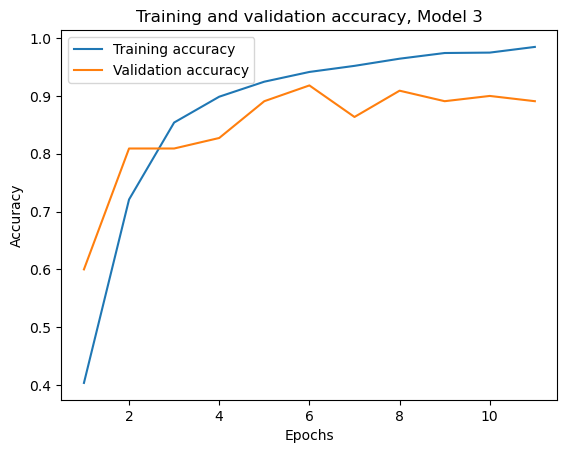

In [32]:
# learning curve
history_dict = model_history[0].history

# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy, Model 3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model3_3.jpeg")

plt.show()

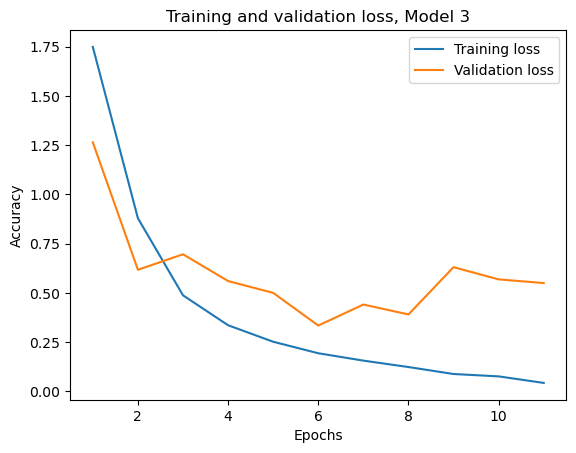

In [33]:
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss, Model 3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model3_4.jpeg")

plt.show()

In [34]:
#training and validation loss
model_3_train_loss=[]
model_3_train_loss.append(np.mean(model_history[0].history['loss']))
print(np.mean(model_3_train_loss)) #0.399

model_3_val_loss=[]
model_3_val_loss.append(np.mean(model_history[0].history['val_loss']))
print(np.mean(model_3_val_loss)) #0.5962

0.3990509621798992
0.5962083122947


In [35]:
#Test model 2
model = load_model('model_3')

#testing loss and accuracy
model.evaluate(X_test, y_test) #0.332, 0.9272

4/4 [==============================] - 1s 83ms/step - loss: 0.3321 - accuracy: 0.9273


[0.3321339786052704, 0.9272727370262146]

In [36]:
#random prediction - test set

preds = model.predict(X_test)
print(preds[109])
print(np.sum(preds[0]))

4/4 [==============================] - 0s 72ms/step
[1.3854239e-05 1.2729606e-03 6.7737041e-05 1.8927149e-05 8.6862528e-01
 1.2804344e-01 2.4287100e-08 2.8453851e-05 3.3940830e-07 1.2617399e-07
 1.9288575e-03]
1.0


In [37]:
#confusion matrix - test set

matrix = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
matrix

array([[10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  9,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  9,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0],
       [ 2,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  9,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  9,  0],
       [ 0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  8]], dtype=int64)

In [38]:
#precision and recall- test set
report_model3 = classification_report(y_test.argmax(axis=1), preds.argmax(axis=1), target_names=categories, output_dict=True)
report_model3 = pd.DataFrame(report_model3).transpose().round(2)
print(report_model3)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.91      1.00      0.95        10
           2       0.83      1.00      0.91        10
           3       1.00      0.90      0.95        10
           4       0.82      0.90      0.86        10
           5       0.91      1.00      0.95        10
           6       1.00      0.80      0.89        10
           7       1.00      0.90      0.95        10
           8       1.00      1.00      1.00        10
           9       1.00      0.90      0.95        10
          10       1.00      0.80      0.89        10

    accuracy                           0.93       110
   macro avg       0.94      0.93      0.93       110
weighted avg       0.94      0.93      0.93       110



<Figure size 640x480 with 0 Axes>

In [ ]:
print(report_model3.to_latex(position='H', bold_rows=True, float_format="{:.2f}".format, label='report_model1', caption='Classification Report, Model 3'))